Predicting a movie's sucess - Logistic & Random Forest Classifier (Full Dataset)

In [1]:
import pyspark

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
spark=SparkSession.builder.appName('movies_model').getOrCreate() 

In [44]:
movies = spark.read.csv('fullmovies.csv',inferSchema=True,header=True)

Selecting the columns that we want to use as predictors

In [45]:
movies = movies.select('titleType','isAdult','startYear','runtimeMinutes','genres','averageRating','numVotes')

In [46]:
movies.show(10)

+---------+-------+---------+--------------+--------------------+-------------+--------+
|titleType|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+-------+---------+--------------+--------------------+-------------+--------+
|    short|    0.0|     1894|             1|   Documentary,Short|          5.6|  1550.0|
|    short|    0.0|     1892|             4|Animation,Comedy,...|          6.5|  1207.0|
|    short|    0.0|     1893|             1|        Comedy,Short|          6.1|  1934.0|
|    short|    0.0|     1894|             1|         Short,Sport|          5.5|   615.0|
|    short|    0.0|     1894|             1|   Documentary,Short|          5.4|  1667.0|
|    short|    0.0|     1895|             1|   Documentary,Short|          6.9|  5545.0|
|    short|    0.0|     1896|             1|Action,Documentar...|          7.4|  9435.0|
|    short|    0.0|     1895|             1|   Documentary,Short|          5.7|  1447.0|
|    short|    0.0|  

Creating a new binary Success column where if the average rating is greater than 7, the movie can be constituted as a success, and if it's less, than it's not.

In [47]:
from pyspark.sql import functions as f
movies = movies.withColumn('Success', f.when(f.col('averageRating') >= 6.4, 1).otherwise(0))
movies.show(5)

+---------+-------+---------+--------------+--------------------+-------------+--------+-------+
|titleType|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|Success|
+---------+-------+---------+--------------+--------------------+-------------+--------+-------+
|    short|    0.0|     1894|             1|   Documentary,Short|          5.6|  1550.0|      0|
|    short|    0.0|     1892|             4|Animation,Comedy,...|          6.5|  1207.0|      1|
|    short|    0.0|     1893|             1|        Comedy,Short|          6.1|  1934.0|      0|
|    short|    0.0|     1894|             1|         Short,Sport|          5.5|   615.0|      0|
|    short|    0.0|     1894|             1|   Documentary,Short|          5.4|  1667.0|      0|
+---------+-------+---------+--------------+--------------------+-------------+--------+-------+
only showing top 5 rows



Delete the average rating column 

In [48]:
movies = movies.drop('averageRating')

Remove the video game title as it doesn't have a run time, and any special characters in the runtime column. 

In [49]:
movies = movies.filter(movies.titleType !='videoGame')   
movies = movies.filter(movies.runtimeMinutes !='\\N') 

Make sure the runtime column is an integer type.

In [50]:
from pyspark.sql.types import IntegerType
movies = movies.withColumn("runtimeMinutes", movies["runtimeMinutes"].cast(IntegerType()))

In [51]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

In [52]:
columns = movies.columns

Convert the string columns to categorical variables that can be used as features.

In [53]:
categoricalColumns = ['genres','titleType','startYear']
stages = []

In [54]:
for i in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = i, outputCol = i + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[i + "classVec"])
    stages += [stringIndexer, encoder]

Create a label column that has a success/failure of a movie.

In [55]:
labelcolumn = StringIndexer(inputCol = 'Success', outputCol = 'Label')
stages += [labelcolumn]

For the numerical columns, we can convert them to a vector and then add it to the existing categorical variables that were created for the initial columns. 

In [56]:
numericColumns = ['runtimeMinutes','numVotes','isAdult']
assembler = [c + "classVec" for c in categoricalColumns] + numericColumns
assembler = VectorAssembler(inputCols=assembler, outputCol="features")
stages += [assembler]

The new movies dataframe should have the existing columns, along with the newly created columns (Features/Label)

In [57]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(movies)
movies = pipelineModel.transform(movies)
selectedColumns = ['label', 'features'] + columns
movies = movies.select(selectedColumns)
movies.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- titleType: string (nullable = true)
 |-- isAdult: double (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- numVotes: double (nullable = true)
 |-- Success: integer (nullable = false)



In [58]:
movies.show(10)

+-----+--------------------+---------+-------+---------+--------------+--------------------+--------+-------+
|label|            features|titleType|isAdult|startYear|runtimeMinutes|              genres|numVotes|Success|
+-----+--------------------+---------+-------+---------+--------------+--------------------+--------+-------+
|  1.0|(1330,[45,1188,13...|    short|    0.0|     1894|             1|   Documentary,Short|  1550.0|      0|
|  0.0|(1330,[221,1188,1...|    short|    0.0|     1892|             4|Animation,Comedy,...|  1207.0|      1|
|  1.0|(1330,[22,1188,13...|    short|    0.0|     1893|             1|        Comedy,Short|  1934.0|      0|
|  1.0|(1330,[616,1188,1...|    short|    0.0|     1894|             1|         Short,Sport|   615.0|      0|
|  1.0|(1330,[45,1188,13...|    short|    0.0|     1894|             1|   Documentary,Short|  1667.0|      0|
|  0.0|(1330,[45,1188,13...|    short|    0.0|     1895|             1|   Documentary,Short|  5545.0|      1|
|  0.0|(13

Next, we can split the data into training & test sets and then start off with Logistic Regression

In [59]:
train, test = movies.randomSplit([0.7, 0.3])

In [60]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
pred_train = lrModel.transform(train)
pred_test = lrModel.transform(test)

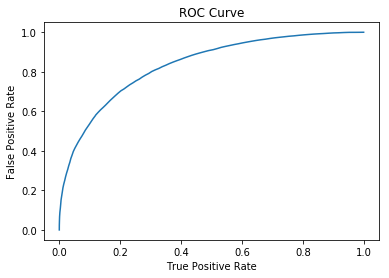

Training Data: Area Under ROC: 0.8333056004562016


In [62]:
import matplotlib.pyplot as plt
import numpy as np

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training Data: Area Under ROC: ' + str(trainingSummary.areaUnderROC))

We can see the probability of a success/failure by including our features.

In [61]:
pred_test.select('titleType','numVotes','runTimeMinutes','startYear','genres', 'Success','prediction', 'probability').show(50)

+---------+---------+--------------+---------+------+-------+----------+--------------------+
|titleType| numVotes|runTimeMinutes|startYear|genres|Success|prediction|         probability|
+---------+---------+--------------+---------+------+-------+----------+--------------------+
|    movie|   5016.0|           122|     2018| Drama|      1|       0.0|[0.68127161038781...|
|    movie|    457.0|           136|     2010| Drama|      1|       0.0|[0.65981349339522...|
|    movie|   3674.0|           106|     2001| Drama|      1|       0.0|[0.63379997090807...|
|    movie|    303.0|            84|     2000| Drama|      1|       0.0|[0.55480525517470...|
|    movie|    772.0|            86|     2000| Drama|      1|       0.0|[0.56079229229445...|
|    movie|    309.0|            87|     2000| Drama|      1|       0.0|[0.56080688490253...|
|    movie|    295.0|            89|     2000| Drama|      1|       0.0|[0.56472161444352...|
|    movie|   1142.0|            92|     2000| Drama|      1

Evaluate our model on the training and test sets

In [63]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Training Data Area Under ROC', evaluator.evaluate(pred_train))
print('Testing Data Area Under ROC', evaluator.evaluate(pred_test))

Training Data Area Under ROC 0.8333383062265413
Testing Data Area Under ROC 0.8103034554825168


Confusion Matrix Terms

True Positive (TP): Correctly predicted to be a positive class.
False Positive (FP): Incorrectly predicted to be a positive class.
True Negative (TN): Correctly predicted to not be a positive class.
False Negative (FN): Incorrectly predicted to not be a positive class.

In [64]:
label_pred_test = pred_test.select('label', 'prediction')
label_pred_test.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(label=0.0, prediction=0.0): 10110,
             Row(label=0.0, prediction=1.0): 2594,
             Row(label=1.0, prediction=0.0): 3207,
             Row(label=1.0, prediction=1.0): 6341})

In [65]:
Recall = 6341/(6341+3207)
Accuracy =  (6341+10110)/(10110+2594+3207+6341)
Precision = 6341/(6341+2594)

In [66]:
print ('Recall',Recall)
print ('Accuracy', Accuracy)
print ('Precision', Precision)

Recall 0.6641181399245916
Accuracy 0.7393043321948589
Precision 0.7096810296586458


Based on the results, it looks like our model has performed fairly well with the Logistic Regression model.

Now let's try to use the Random Forest classifier to see if we can get a better model!

In [67]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfpred_train = rfModel.transform(train)
rfpred_test = rfModel.transform(test)

In [68]:
rfpred_test.select('titleType','numVotes','runTimeMinutes','genres','startYear','Success','prediction', 'probability').show(50)

+---------+---------+--------------+------+---------+-------+----------+--------------------+
|titleType| numVotes|runTimeMinutes|genres|startYear|Success|prediction|         probability|
+---------+---------+--------------+------+---------+-------+----------+--------------------+
|    movie|   5016.0|           122| Drama|     2018|      1|       0.0|[0.57430694239223...|
|    movie|    457.0|           136| Drama|     2010|      1|       0.0|[0.56981797878214...|
|    movie|   3674.0|           106| Drama|     2001|      1|       0.0|[0.56070370021515...|
|    movie|    303.0|            84| Drama|     2000|      1|       0.0|[0.55621473660505...|
|    movie|    772.0|            86| Drama|     2000|      1|       0.0|[0.55621473660505...|
|    movie|    309.0|            87| Drama|     2000|      1|       0.0|[0.55621473660505...|
|    movie|    295.0|            89| Drama|     2000|      1|       0.0|[0.55621473660505...|
|    movie|   1142.0|            92| Drama|     2000|      1

In [69]:
print('Train Area Under ROC', evaluator.evaluate(rfpred_train))
print('Test Area Under ROC', evaluator.evaluate(rfpred_test))

Train Area Under ROC 0.7369100901206973
Test Area Under ROC 0.7284965170676807


Generate the confusion matrix to calculate the metrics

In [70]:
label_rfpred_test = rfpred_test.select('label', 'prediction')
label_rfpred_test.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(label=0.0, prediction=0.0): 12634,
             Row(label=0.0, prediction=1.0): 70,
             Row(label=1.0, prediction=0.0): 9007,
             Row(label=1.0, prediction=1.0): 541})

In [71]:
rfRecall = 541/(541+9007)
rfAccuracy = (541+12634)/(12634+70+9007+541)
rfPrecision = 541/(541+70)

In [72]:
print ('Recall',rfRecall)
print ('Accuracy', rfAccuracy)
print ('Precision', rfPrecision)

Recall 0.056661080854629245
Accuracy 0.59208161064174
Precision 0.8854337152209493


Based on the analysis above, we can conclude that the Logistic regression model has performed much better than the Random Forest. The Random forest model has performed quite poorly compared to the initial model, so additional tuning to the parameters might be required. 

